In [5]:
# Import libraries 
from matplotlib import cycler
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import yfinance as yf

In [6]:
# facecolor_theme = '#222222'      #origamid theme 
# facecolor_theme = '#FFFFFF'      #github light default 
# facecolor_theme = '#0d1117'      #github dark web 
facecolor_theme = '#1f1f1f'        #modern dark

colors = cycler('color', 
                ['#669FEE', '#66EE91', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor = facecolor_theme)
plt.rc('axes', facecolor = facecolor_theme, edgecolor = '#1f1f1f',
       axisbelow = True, grid = True, prop_cycle = colors,
       labelcolor = 'white')
plt.rc('xtick', color = 'white')
plt.rc('ytick', direction = 'out', color = 'white')
plt.rc('legend', facecolor = facecolor_theme, edgecolor = facecolor_theme)
plt.rc('text', color = 'white')
plt.rc('figure', facecolor = facecolor_theme)

# Set grid lines to be thin
plt.rc('grid', linewidth=0.1, color='white')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from binance import Client
from dotenv import load_dotenv
import os 

# Chargez les variables d'environnement à partir du fichier .env
load_dotenv()

# Accédez à vos clés d'API à l'aide de variables d'environnement
API_KEY = os.getenv("BINANCE_API_KEY")
SECRET_KEY = os.getenv("BINANCE_API_SECRET")

client = Client(API_KEY, SECRET_KEY) 

In [7]:
def preprocessing(asset):
    
    # Import data 
    df = yf.download(asset).dropna()
    
    # Rename columns 
    df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
    df.index.name = 'time'
    
    # Remove adj close 
    df = df.drop('adj close', axis=1)
    
    return df

# Preprocessing function

In [ ]:
def preprocessing(asset, interval):
    
    klines  = client.get_historical_klines(asset, interval)
    klines = [[x[0], float(x[1]), float(x[2]), float(x[3]),
              float(x[4]), float(x[5])] for x in klines]
    klines = pd.DataFrame(klines, columns =['date', 'open',
                                           'high', 'low', 
                                            'close', 'volume'])
    klines['date'] = pd.to_datetime(klines['date'], unit = 'ms')
    klines = klines.set_index('date')
    
    return klines

In [8]:
# Parameters 
asset = 'BTC'
#interval = Client.KLINE_INTERVAL_1DAY   

# Use defined functions 
df = preprocessing(f"{asset}-USD")

# Show the dataframe 
df.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


# Support & Resistance

In [9]:
# Create Resistance using a rolling max
df["resistance"] = df["close"].rolling(30).max().shift(3)

# Create Support using a rolling min
df["support"] = df["close"].rolling(30).min().shift(3)

<AxesSubplot:xlabel='time'>

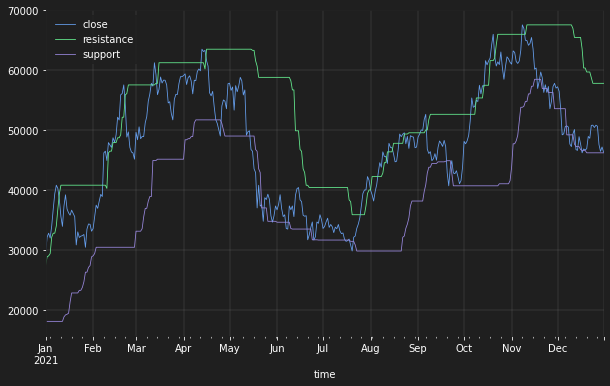

In [10]:
# Plot the results
df[["close", "resistance", "support"]].loc["2021"].plot(figsize=(10, 6), linewidth = 0.8)

# Strategy

In [11]:
# Safety distance
distance = 0.5/100

# Shift the values
df["close yersteday"] = df["close"].shift(1)
df["resistance yersteday"] = df["resistance"].shift(1)
df["signal_long"] = np.nan


# Create the condition
df.loc[(df["close yersteday"] < df["resistance yersteday"]) & \
       (df["close"] > df["resistance"]*(1+distance)), "signal_long"] = 1

df["signal_long"] = df["signal_long"].fillna(value=0)

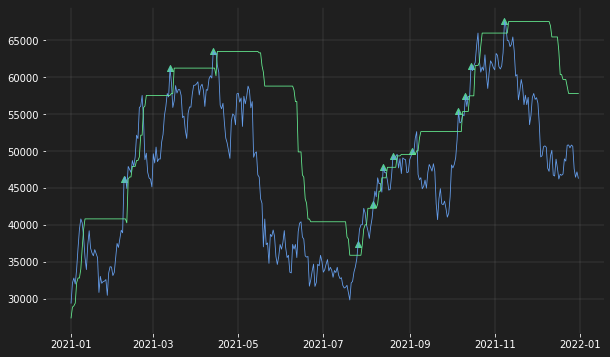

In [12]:
# We plot all the signal to be sure that they be correct

year = "2021"

# Select all signal in a index list to plot only this points
idx_open = df.loc[df["signal_long"] == 1].loc[year].index

# Adapt the size of the graph
plt.figure(figsize=(10,6))

# Plot the points of the open long signal in green
plt.scatter(idx_open, df.loc[idx_open]["close"].loc[year], color= "#57CE95", marker="^")

# Plot the resistance to be sure that the conditions are completed
plt.plot(df["close"].loc[year].index, df["close"].loc[year], linewidth=0.8)
plt.plot(df["close"].loc[year].index, df["resistance"].loc[year], linewidth=0.8)

# Show the graph
plt.show()

# Compute the profit

<AxesSubplot:xlabel='time'>

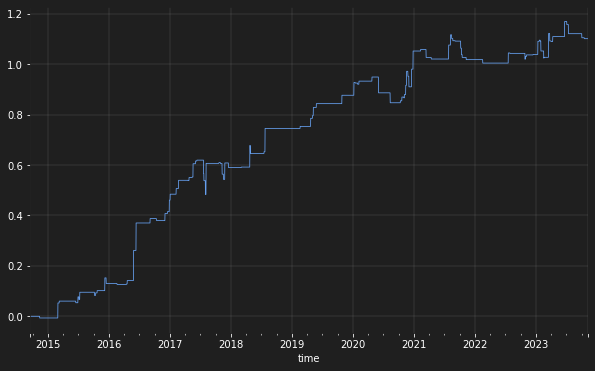

In [13]:
# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = df["pct"] * (df["signal_long"].shift(1))

df["return"].cumsum().plot(figsize=(10, 6), linewidth = 0.8)

# Crypto Strategy : Breakout

In [14]:
def breakout(df, cost=0.01, duration=7):
    df['resistance'] = df['close'].rolling(30).max().shift(3)
    df['support'] = df['close'].rolling(30).min().shift(3)
    
    distance = 0.5 / 100 
    
    # Shift the values 
    df['Close Yesterday'] = df['close'].shift(1)    
    df['Resistance Yesterday'] = df['resistance'].shift(1)  
    df['signal_long'] = np.nan
    
    df.loc[(df['close'] > df['resistance'] * (1 + distance)) &\
           (df['Close Yesterday'] < df["Resistance Yesterday"]), 'signal_long'] = 1
    
    df['signal_long'] = df['signal_long'].fillna(value=0)
    
    # Compute the percentage of variation of the asset 
    df['pct'] = df['close'].pct_change(1)
    
    # Compute the return of the strategy 
    df['return'] = np.array([df['pct'].shift(1) for i in range(duration)]).sum(axis=0) * (df['signal_long'].shift(duration))
    
    df.loc[df['signal_long'] == 1, 'return'] = df['return'] - cost 
    
    return df['return']

<AxesSubplot:xlabel='time'>

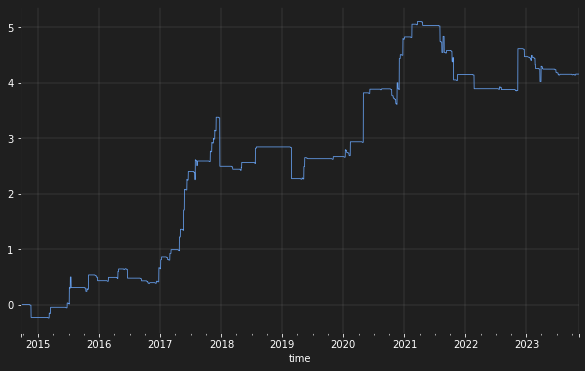

In [15]:
breakout(df, duration=7).fillna(value=0).cumsum().plot(figsize=(10, 6), linewidth = 0.8)

In [16]:
# Create empty dataframe
dft = pd.DataFrame()

namelist = ["BTC", "ETH", "LTC", "MATIC", "ETC"]
#interval = Client.KLINE_INTERVAL_1DAY   

for name in namelist:
  # Manage the data
  df = preprocessing(f"{name}-USD")

  # Create the strategy
  dfc = breakout(df, duration=7)

  # Rename return
  dfc.rename = name

  # drop the nan
  dft[name] = dfc.fillna(value=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='time'>

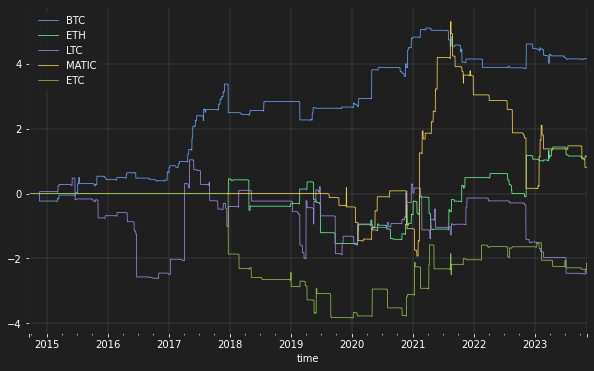

In [17]:
dft.fillna(value=0).cumsum(axis=0).plot(figsize=(10, 6), linewidth = 0.8)